In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
# from fastai2.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

# MaskRCNN Data Utils
from semtorch.models.archs.mask_rcnn import MaskRCNNBlock, IntToFloatTensorMaskRCNN, TfmdDLV2, MaskRCNNDict

# MaskRCNN metrics
from semtorch.utils.metrics import DiceMaskRCNN, JaccardCoeffMaskRCNN


from pathlib import Path
import random

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
%matplotlib inline
import numpy as np

Function por stablishing the seed for reproducibility

In [3]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
path = Path("../datasets/")
path_images = path/"Images"
path_labels = path/"Labels"

test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [5]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels").replace(".png",".tif"))

Aux function for splitting between training and testing

In [6]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

Loading the codes of the different classes. All the datasets have the same codes.

In [7]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
void_code = name2id['Tumor']

def tumour(input, target):
    res=0
    for i in range(len(input)):
        inputAux=input[i]["masks"]
        targetAux=target[i]["masks"]
        targetAux = targetAux.squeeze(1)

        if inputAux.shape[0]>0:
            inputAux=inputAux[0]
        else:
            inputAux=torch.zeros(targetAux.shape).to(targetAux.device)

        #print(input.shape)
        #print(target.shape)
        mask = targetAux != void_code
        res+=(inputAux[mask]==targetAux[mask]).float().mean()
    return res/len(input)

{'NoTumor': 0, 'Tumor': 1}


Early Stopping parameters

In [8]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=2

In [9]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [10]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,target = x
#         print(img.shape)
#         print(target["masks"])
#         print("AUG TRANSFORM ",np.array(target["masks"])[0].shape)
        
#         img1 = img
#         img1.show(figsize=(5, 5))
#         mask1 = PILMask.create(np.array(target["masks"])[0])
#         mask1.show(figsize=(5, 5), alpha=1)
        
        # Transform
#         print('Despues')
        #print(np.array(img).shape)
        #print(np.array(target["masks"]))
        aug = self.aug(image=np.array(img), mask=np.array(target["masks"])[0])
        
        target["masks"]=aug["mask"]
        pos = np.where(target["masks"])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        
        target["masks"]=np.expand_dims(target["masks"], axis=0)
        target["masks"]=TensorMask(target["masks"])
        #print("AUG ",target["masks"].shape)
        target["boxes"]=TensorBBox.create([xmin, ymin, xmax, ymax])
        
#         img2 = PILImage.create(aug["image"])
#         img2.show(figsize=(5, 5))
#         mask2 = PILMask.create(np.array(target["masks"])[0])
#         mask2.show(figsize=(5, 5), alpha=1)
        
        return PILImage.create(aug["image"]), target
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10)
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

Definition of the splitter for saying the learner what weights of the network to freeze

In [11]:
def maskrcnn_splitter(model):
    return [params(model.backbone), params(model.rpn), params(model.roi_heads)]

Importing all the functions needed for Mask-RCNN

The getters for DataBlock. Returning same image as input and get dict of image as target

In [12]:
def get_bbox(o):
    label_path = get_y_fn(o)
    mask=PILMask.create(label_path)
    pos = np.where(mask)
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    
    return TensorBBox.create([xmin, ymin, xmax, ymax])
    
def get_bbox_label(o):
    
    return TensorCategory([1])

def get_mask(o):
    label_path = get_y_fn(o)
    mask=PILMask.create(label_path)
    mask = np.array(mask)

    # Change 255 for 1
    mask[mask==255]=1

    # Back to PILMask
    mask = PILMask.create(mask)
    mask=image2tensor(mask)
    return TensorMask(mask)

def get_dict(o):
    return {"boxes": get_bbox(o), "labels": get_bbox_label(o),"masks": get_mask(o)}

getters = [lambda o: o, get_dict]

# Mask-RCNN

## Manual Annotations

In [13]:
manual_name="manual"

In [14]:
path_manual_img = path_images/manual_name
path_manual_lbl = path_labels/manual_name

../datasets/Images/manual/341.png


<AxesSubplot:>

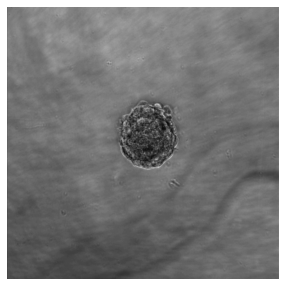

In [15]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [16]:
print(get_y_fn(img_f))

../datasets/Labels/manual/341.tif


<AxesSubplot:>

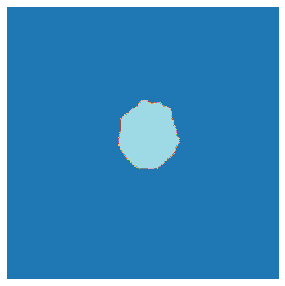

In [17]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
print(torch.max(image2tensor(mask)))

tensor(255, dtype=torch.uint8)


<AxesSubplot:>

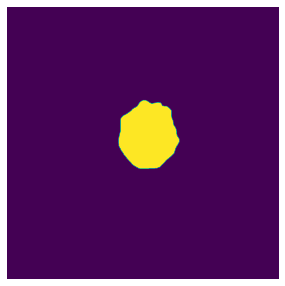

In [19]:
mask = PILMask.create(get_y_fn(img_f))
mask=image2tensor(mask)
example = {"boxes": 1, "labels": 1,"masks": mask}
s=MaskRCNNDict(example)
s.show()

In [20]:
size = 1002
bs = 2

### No Data Augmentation

#### Hyper-parameter Selection

We are going to adjust weight decay.

In [21]:
maskrccnnDataBlock = DataBlock(
    blocks=(ImageBlock, MaskRCNNBlock),
    get_items=partial(get_image_files,folders=[manual_name]),
    getters=getters,
    splitter=RandomSplitter(valid_pct=0.1,seed=2020),
    item_tfms=[IntToFloatTensorMaskRCNN],
    dl_type=TfmdDLV2,
    n_inp=1
)
maskrccnnDataBlock.summary(path_images)
print("Batch Size {}".format(bs))
dls = maskrccnnDataBlock.dataloaders(path_images,bs=bs)

Setting-up type transforms pipelines
Found 621 items
2 datasets of sizes 559,62
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: get_dict -> MaskRCNNDict.create

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying <lambda> gives
      ../datasets/Images/manual/165.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: get_dict -> MaskRCNNDict.create
    starting from
      ../datasets/Images/manual/165.png
    applying get_dict gives
      {'boxes': TensorBBox([[425., 387., 641., 591.]]), 'labels': TensorCategory([1]), 'masks': TensorMask([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)}
    applying MaskRCNNDict.create gives
      {'boxes': TensorBBox([[425., 387., 641.

WD=1e-2

In [22]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-2,
                                 splitter=maskrcnn_splitter)

# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

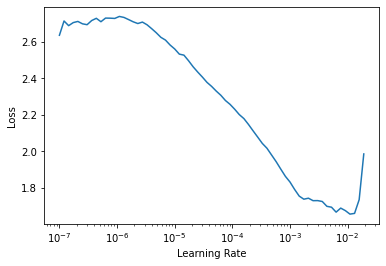

In [24]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.364307,0.275310,0.967807,0.734807,0.580786,01:03
1,0.190004,0.189460,0.943142,0.919192,0.850467,01:02
2,0.167684,0.133809,0.944689,0.937770,0.882831,01:04
3,0.150246,0.141680,0.946883,0.913682,0.841082,01:03
4,0.122714,0.129663,0.954464,0.941168,0.888874,01:05
5,0.112923,0.117029,0.949979,0.945731,0.897050,01:05
6,0.097534,0.110276,0.955421,0.946390,0.898236,01:03
7,0.087084,0.104516,0.951649,0.949817,0.904430,01:03
8,0.086650,0.107199,0.952816,0.950880,0.906360,01:02
9,0.078538,0.106552,0.952618,0.950976,0.906534,01:03


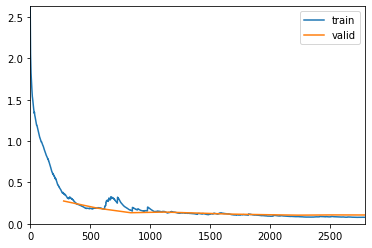

No improvement since epoch 7: early stopping


In [25]:
fname="maskrcnn-resnet50-manual-no-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [23]:
learn.load("maskrcnn-resnet50-manual-no-data-augmentation-before-unfreeze-WD-2-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.11850544810295105,0.9516485929489136,0.9498168146835666,0.9044296537630955]

Recorder

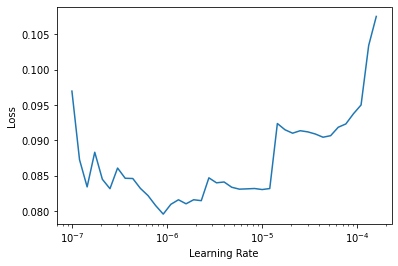

In [25]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.082950,0.103723,0.950647,0.950146,0.905028,01:58
1,0.083631,0.101905,0.951689,0.950504,0.905676,02:00
2,0.081194,0.099499,0.951873,0.951299,0.907121,02:00
3,0.081804,0.100997,0.952402,0.951703,0.907856,02:00
4,0.082385,0.098825,0.952658,0.951768,0.907974,02:00
5,0.077483,0.099370,0.952071,0.952056,0.908498,02:00
6,0.075491,0.097557,0.952632,0.952122,0.908619,02:00
7,0.073740,0.097496,0.952486,0.952275,0.908898,02:00
8,0.078551,0.096752,0.952499,0.952478,0.909268,01:58
9,0.074267,0.096961,0.952912,0.952628,0.909541,01:59


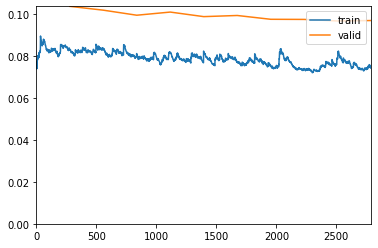

In [26]:
fname="maskrcnn-resnet50-manual-no-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(4e-7,8e-7),cbs=callbacksFitAfterUnfreeze)

WD=1e-1

In [22]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-1,
                                 splitter=maskrcnn_splitter)
# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

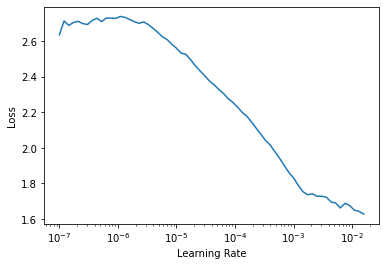

In [24]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.355763,0.232567,0.968859,0.824386,0.701238,01:00
1,0.225436,0.194390,0.939389,0.922367,0.855919,01:01
2,0.153320,0.140388,0.943718,0.936837,0.881178,01:00
3,0.141291,0.139857,0.944036,0.909838,0.834589,01:01
4,0.134098,0.140394,0.951057,0.940219,0.887182,01:01
5,0.113986,0.132111,0.948109,0.944467,0.894777,01:01
6,0.097727,0.107136,0.955737,0.947816,0.900808,01:01
7,0.086450,0.106477,0.953492,0.950708,0.906047,01:01
8,0.085935,0.106053,0.952968,0.951577,0.907627,01:01
9,0.079716,0.106494,0.952815,0.951912,0.908237,01:01


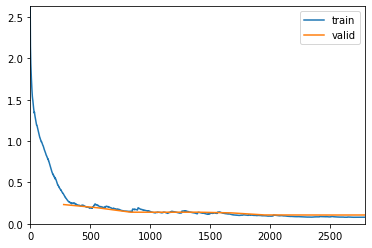

In [25]:
fname="maskrcnn-resnet50-manual-no-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [23]:
learn.load("maskrcnn-resnet50-manual-no-data-augmentation-before-unfreeze-WD-1-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.11814666539430618,0.9529683589935303,0.951576771470202,0.9076265629907843]

Recorder

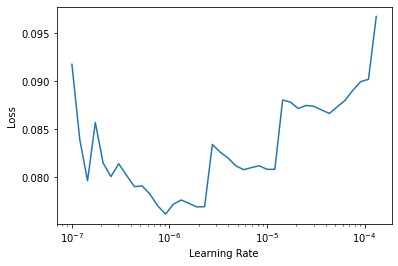

In [25]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.079993,0.108057,0.952786,0.951909,0.908231,01:53
1,0.080481,0.105399,0.953557,0.951673,0.907802,01:56
2,0.078643,0.104403,0.952999,0.952213,0.908784,01:54
3,0.078376,0.102805,0.953056,0.952458,0.909231,01:54
4,0.078101,0.102955,0.953651,0.952507,0.909321,01:54
5,0.075424,0.104393,0.952999,0.952850,0.909946,01:54


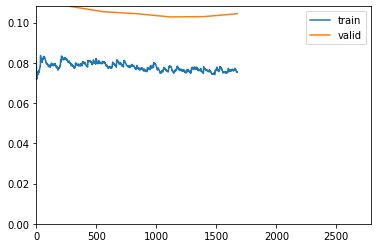

No improvement since epoch 3: early stopping


In [26]:
fname="maskrcnn-resnet50-manual-no-data-augmentation-after-unfreeze-WD-1-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-7,9e-7),cbs=callbacksFitAfterUnfreeze)

#### Evaluation - Best hyperparameters

In [21]:
manual = DataBlock(
    blocks=(ImageBlock, MaskRCNNBlock),
    get_items=partial(get_image_files,folders=[manual_name,test_name]),
    getters=getters,
    splitter=FuncSplitter(ParentSplitter),
    item_tfms=[IntToFloatTensorMaskRCNN],
    dl_type=TfmdDLV2,
    n_inp=1
)
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)

Setting-up type transforms pipelines
Found 987 items
2 datasets of sizes 621,366
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: get_dict -> MaskRCNNDict.create

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying <lambda> gives
      ../datasets/Images/manual/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: get_dict -> MaskRCNNDict.create
    starting from
      ../datasets/Images/manual/416.png
    applying get_dict gives
      {'boxes': TensorBBox([[299., 288., 742., 712.]]), 'labels': TensorCategory([1]), 'masks': TensorMask([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)}
    applying MaskRCNNDict.create gives
      {'boxes': TensorBBox([[299., 288., 742

In [22]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-2,
                                 splitter=maskrcnn_splitter)
# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

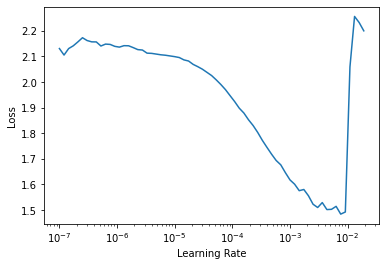

In [24]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.308704,0.331914,0.926158,0.815775,0.688868,01:45
1,0.188683,0.311373,0.944560,0.851764,0.741803,01:46
2,0.260793,0.328218,0.938077,0.887520,0.797785,01:46
3,0.147402,0.264613,0.927122,0.900670,0.819291,01:46
4,0.116220,0.320988,0.927289,0.908284,0.831978,01:46
5,0.110904,0.225045,0.926855,0.921389,0.854236,01:47
6,0.092392,0.216969,0.926851,0.931057,0.871007,01:46
7,0.086710,0.205558,0.925497,0.932604,0.873719,01:47
8,0.082308,0.218879,0.927304,0.932866,0.874179,01:46
9,0.077705,0.218157,0.928864,0.934070,0.876296,01:46


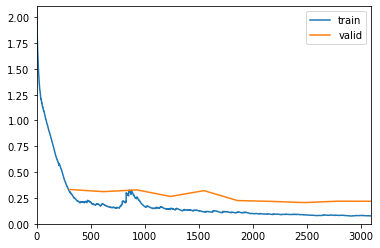

In [25]:
fname="maskrcnn-resnet50-manual-no-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [24]:
learn.load("maskrcnn-resnet50-manual-no-data-augmentation-before-unfreeze-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


(#4) [0.21806132793426514,0.9288643598556519,0.9340701206884136,0.8762960292394352]

Recorder

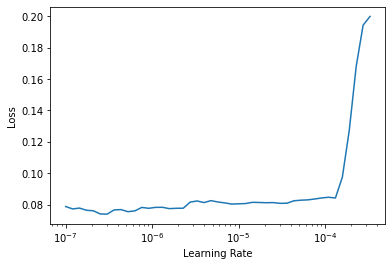

In [25]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.076647,0.218668,0.929031,0.934104,0.876355,02:45
1,0.080122,0.218503,0.928142,0.934602,0.877233,02:46
2,0.078527,0.218488,0.928453,0.934919,0.877791,02:46
3,0.077459,0.217980,0.928056,0.934951,0.877848,02:45
4,0.074127,0.218723,0.927178,0.934356,0.876799,02:44
5,0.076932,0.220138,0.928076,0.935102,0.878114,02:46
6,0.072551,0.219921,0.928463,0.934937,0.877823,02:46
7,0.074887,0.220012,0.928259,0.934966,0.877875,02:46


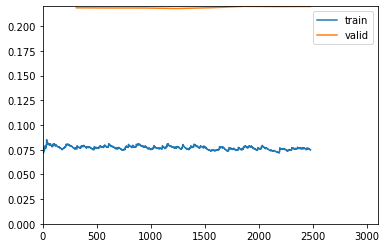

No improvement since epoch 5: early stopping


In [26]:
fname="maskrcnn-resnet50-manual-no-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-7,3e-7),cbs=callbacksFitAfterUnfreeze)

In [23]:
learn.load("maskrcnn-resnet50-manual-no-data-augmentation-after-unfreeze-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.23221483826637268,0.9280762672424316,0.9351020641767361,0.8781142612074052]

In [28]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("TorchScript models/mask-rcnn-dataset1-no-data-augmentation.pth")

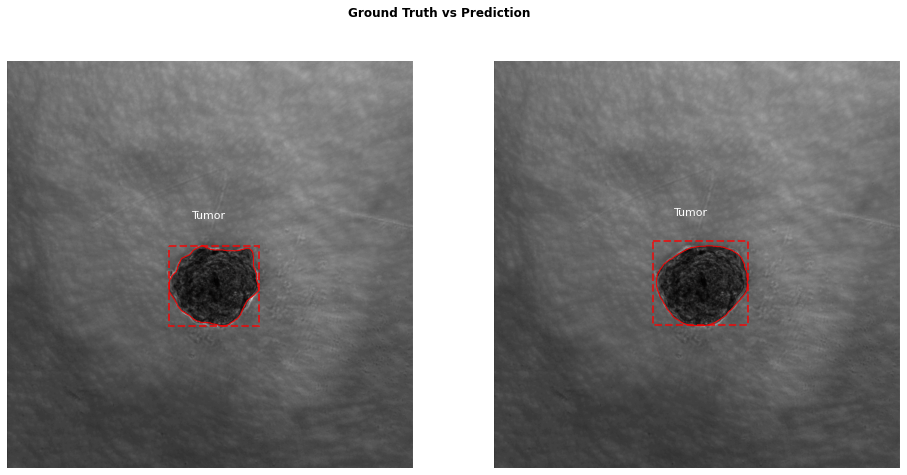

In [30]:
learn.show_results() # show results

### Data Augmentation

In [21]:
manual = DataBlock(
    blocks=(ImageBlock, MaskRCNNBlock),
    get_items=partial(get_image_files,folders=[manual_name]),
    getters=getters,
    splitter=RandomSplitter(valid_pct=0.1,seed=2020),
    item_tfms=[transformPipeline,IntToFloatTensorMaskRCNN],
    dl_type=TfmdDLV2,
    n_inp=1
)
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)

Setting-up type transforms pipelines
Found 621 items
2 datasets of sizes 559,62
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: get_dict -> MaskRCNNDict.create

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying <lambda> gives
      ../datasets/Images/manual/165.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: get_dict -> MaskRCNNDict.create
    starting from
      ../datasets/Images/manual/165.png
    applying get_dict gives
      {'boxes': TensorBBox([[425., 387., 641., 591.]]), 'labels': TensorCategory([1]), 'masks': TensorMask([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)}
    applying MaskRCNNDict.create gives
      {'boxes': TensorBBox([[425., 387., 641.

WD=1e-3

In [22]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-3,
                                 splitter=maskrcnn_splitter)
# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

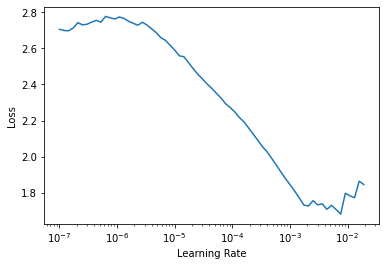

In [24]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.378305,0.232132,0.965487,0.821598,0.697214,01:00
1,0.200593,0.258647,0.920152,0.893237,0.807072,00:59
2,0.209412,0.148202,0.947666,0.931401,0.871610,01:00
3,0.189720,0.240358,0.946721,0.898174,0.815169,01:00
4,0.137694,0.131825,0.952888,0.939028,0.885064,01:00
5,0.126917,0.126610,0.950030,0.942378,0.891036,01:00
6,0.109905,0.107672,0.954438,0.944850,0.895465,01:00
7,0.101755,0.104916,0.955327,0.948559,0.902151,01:00
8,0.104367,0.097982,0.951414,0.949535,0.903918,01:00
9,0.095902,0.098217,0.952413,0.949477,0.903813,01:00


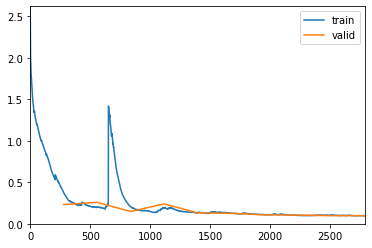

In [25]:
fname="maskrcnn-resnet50-manual-data-augmentation-before-unfreeze-WD-3-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [23]:
learn.load("maskrcnn-resnet50-manual-data-augmentation-before-unfreeze-WD-3-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.11172148585319519,0.9514136910438538,0.9495347726284303,0.9039183286478856]

Recorder

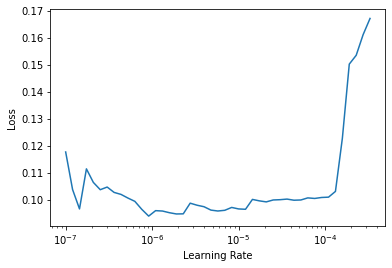

In [25]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.099009,0.098174,0.951442,0.949678,0.904177,01:54
1,0.097548,0.098020,0.952560,0.950002,0.904765,01:54
2,0.097047,0.096152,0.951798,0.950271,0.905255,01:54
3,0.097505,0.097915,0.952394,0.950357,0.905410,01:55
4,0.097546,0.095728,0.952181,0.950789,0.906194,01:55
5,0.092116,0.097264,0.951354,0.950707,0.906046,01:55
6,0.091452,0.095452,0.951089,0.950647,0.905936,01:55
7,0.088883,0.094791,0.950972,0.950773,0.906166,01:55
8,0.094687,0.095006,0.950948,0.950819,0.906249,01:59
9,0.090839,0.095012,0.950875,0.950804,0.906222,02:01


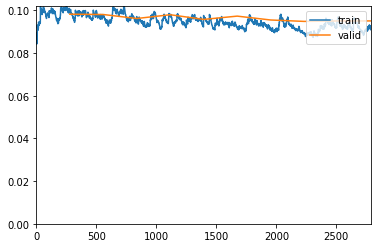

No improvement since epoch 7: early stopping


In [26]:
fname="maskrcnn-resnet50-manual-data-augmentation-after-unfreeze-WD-3-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-7,8e-7),cbs=callbacksFitAfterUnfreeze)

WD=1e-2

In [22]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-2,
                                 splitter=maskrcnn_splitter)
# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

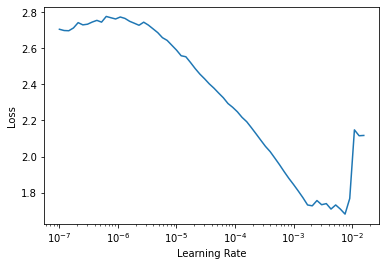

In [24]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.357886,0.224471,0.963004,0.818193,0.692324,00:59
1,0.214573,0.342488,0.927141,0.887348,0.797507,01:00
2,0.157253,0.175665,0.943968,0.922032,0.855343,01:00
3,0.154271,0.134879,0.946437,0.937445,0.882255,01:00
4,0.127513,0.132630,0.955334,0.932406,0.873371,01:01
5,0.112996,0.106789,0.955113,0.946922,0.899195,01:01
6,0.104856,0.101484,0.954274,0.948646,0.902309,01:01
7,0.095999,0.096681,0.951357,0.949992,0.904748,01:01
8,0.094833,0.094793,0.953545,0.951210,0.906960,01:01
9,0.089795,0.093858,0.954013,0.951491,0.907470,01:01


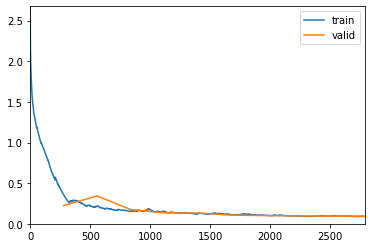

In [25]:
fname="maskrcnn-resnet50-manual-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [23]:
learn.load("maskrcnn-resnet50-manual-data-augmentation-before-unfreeze-WD-2-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.10504411906003952,0.9540132880210876,0.9514907029867279,0.907469972557319]

Recorder

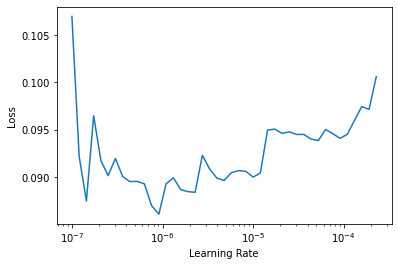

In [25]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.093353,0.092792,0.953627,0.951590,0.907651,01:53
1,0.091113,0.094063,0.954141,0.951817,0.908064,01:54
2,0.089139,0.092689,0.952918,0.952296,0.908936,01:54
3,0.091143,0.092008,0.954155,0.952380,0.909089,01:55
4,0.087633,0.093187,0.953170,0.952516,0.909337,01:55
5,0.086678,0.090539,0.952699,0.952596,0.909483,01:55
6,0.084866,0.091092,0.952158,0.952735,0.909737,01:55
7,0.082567,0.091001,0.952941,0.952845,0.909937,01:55


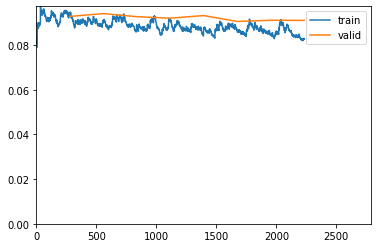

No improvement since epoch 5: early stopping


In [26]:
fname="maskrcnn-resnet50-manual-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(4e-7,8e-7),cbs=callbacksFitAfterUnfreeze)

WD=1e-1

In [22]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-1,
                                 splitter=maskrcnn_splitter)
# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

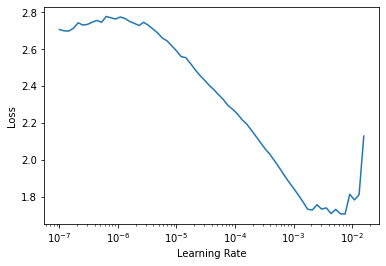

In [24]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.358206,0.222873,0.969803,0.830011,0.709417,01:01
1,0.226390,0.261202,0.939581,0.905092,0.826637,01:00
2,0.164055,0.135441,0.957272,0.931940,0.872554,01:00
3,0.176176,0.137022,0.948409,0.938615,0.884330,01:01
4,0.145091,0.126511,0.950461,0.941079,0.888715,01:01
5,0.119572,0.115697,0.955440,0.945161,0.896024,01:01
6,0.111526,0.109030,0.953396,0.946487,0.898411,01:01
7,0.100170,0.099324,0.953959,0.949892,0.904566,01:01
8,0.100436,0.096159,0.954206,0.950308,0.905321,01:01
9,0.094223,0.094509,0.954086,0.950627,0.905899,01:01


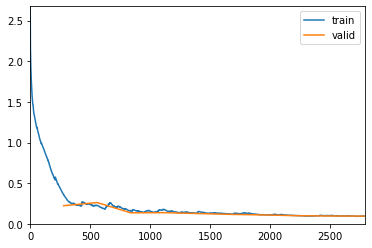

In [25]:
fname="maskrcnn-resnet50-manual-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [23]:
learn.load("maskrcnn-resnet50-manual-data-augmentation-before-unfreeze-WD-1-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.10790194571018219,0.9540858864784241,0.9506266524277698,0.9058993680629348]

Recorder

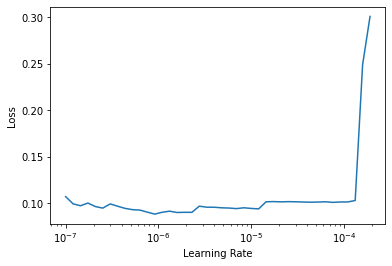

In [25]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.095323,0.096004,0.953589,0.950744,0.906113,01:54
1,0.094038,0.095264,0.954808,0.951070,0.906705,01:54
2,0.093869,0.095160,0.954592,0.951537,0.907555,01:54
3,0.097312,0.092884,0.954568,0.951562,0.907600,01:55
4,0.093566,0.093384,0.954478,0.951886,0.908189,01:55
5,0.090128,0.091063,0.954496,0.951746,0.907934,01:55
6,0.088950,0.092242,0.954456,0.952059,0.908505,01:56
7,0.088301,0.091326,0.954346,0.952232,0.908820,01:57


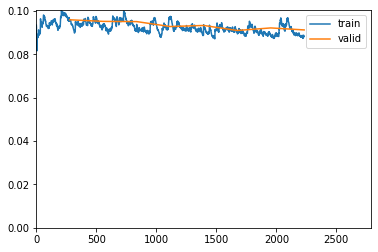

No improvement since epoch 5: early stopping


In [26]:
fname="maskrcnn-resnet50-manual-data-augmentation-after-unfreeze-WD-1-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-7,9e-7),cbs=callbacksFitAfterUnfreeze)

####  Evaluation - Best hyperparameters

In [21]:
manual = DataBlock(
    blocks=(ImageBlock, MaskRCNNBlock),
    get_items=partial(get_image_files,folders=[manual_name,test_name]),
    getters=getters,
    splitter=FuncSplitter(ParentSplitter),
    item_tfms=[transformPipeline, IntToFloatTensorMaskRCNN],
    dl_type=TfmdDLV2,
    n_inp=1
)
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)

Setting-up type transforms pipelines
Found 987 items
2 datasets of sizes 621,366
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: get_dict -> MaskRCNNDict.create

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying <lambda> gives
      ../datasets/Images/manual/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: get_dict -> MaskRCNNDict.create
    starting from
      ../datasets/Images/manual/416.png
    applying get_dict gives
      {'boxes': TensorBBox([[299., 288., 742., 712.]]), 'labels': TensorCategory([1]), 'masks': TensorMask([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)}
    applying MaskRCNNDict.create gives
      {'boxes': TensorBBox([[299., 288., 742

In [22]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-2,
                                 splitter=maskrcnn_splitter)
# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

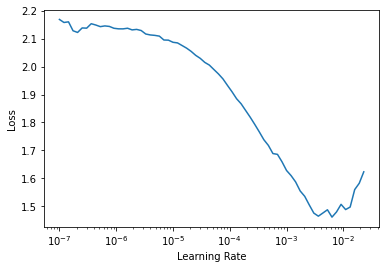

In [24]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.314142,0.309544,0.915903,0.822546,0.698580,01:45
1,0.200377,0.326891,0.905661,0.867334,0.765746,01:45
2,0.188320,0.259933,0.931064,0.899023,0.816569,01:45
3,0.159756,0.268064,0.910245,0.895633,0.810992,01:46
4,0.117702,0.236752,0.932818,0.914454,0.842391,01:46
5,0.116450,0.219608,0.931473,0.923892,0.858549,01:46
6,0.098615,0.197807,0.930521,0.929699,0.868633,01:46
7,0.097794,0.201550,0.930333,0.931278,0.871394,01:46
8,0.094512,0.195169,0.929834,0.931870,0.872432,01:47
9,0.090911,0.194848,0.930383,0.933466,0.875233,01:46


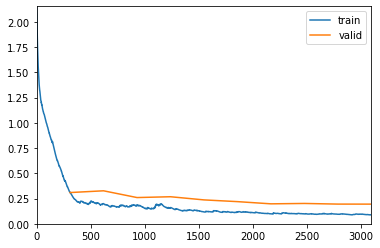

In [25]:
fname="maskrcnn-resnet50-manual-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [24]:
learn.load("maskrcnn-resnet50-manual-data-augmentation-before-unfreeze-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


(#4) [0.19472230970859528,0.9303833246231079,0.9334656930634717,0.8752326924623008]

Recorder

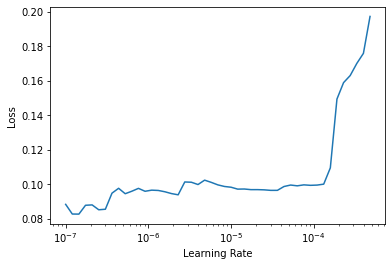

In [25]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.093444,0.193273,0.930755,0.933566,0.875409,02:45
1,0.094654,0.192143,0.930112,0.933848,0.875906,02:46
2,0.091351,0.190826,0.929313,0.934504,0.877060,02:46
3,0.093334,0.187294,0.929934,0.935610,0.879010,02:46
4,0.086783,0.184813,0.928353,0.935923,0.879562,02:47
5,0.089757,0.185778,0.929379,0.935947,0.879606,02:46
6,0.084139,0.186215,0.929308,0.935579,0.878956,02:46
7,0.088837,0.185376,0.929568,0.935730,0.879223,02:46


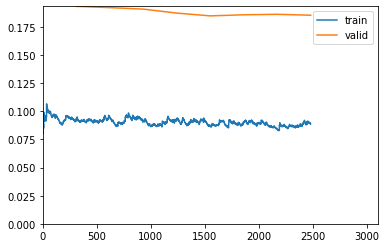

No improvement since epoch 5: early stopping


In [26]:
fname="maskrcnn-resnet50-manual-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,3e-7),cbs=callbacksFitAfterUnfreeze)

In [23]:
learn.load("maskrcnn-resnet50-manual-data-augmentation-after-unfreeze-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.19904600083827972,0.9293785691261292,0.9359473182382059,0.8796061833033688]

In [25]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("TorchScript models/mask-rcnn-dataset1-data-augmentation.pth")

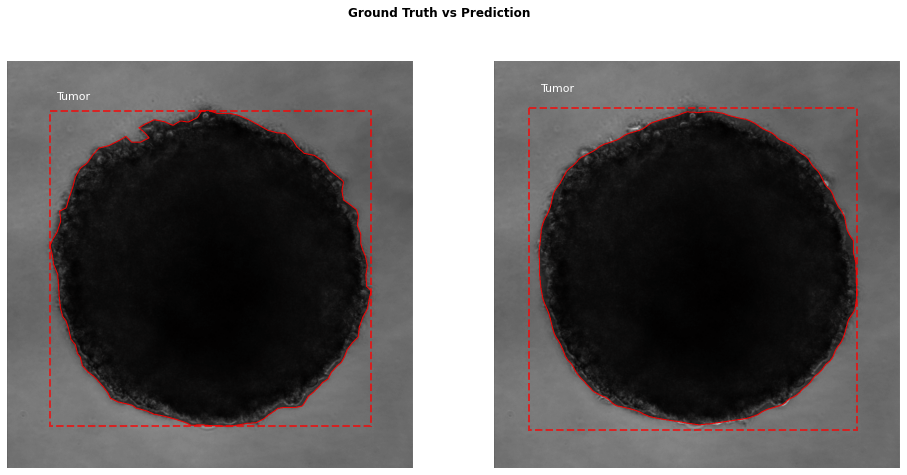

In [32]:
learn.show_results() # show results

## Manual + SpheroidJ Annotations

In [13]:
manual_spheroidj_name = "manual + spheroidj"

In [14]:
path_manual_plus_spheroidj_clear_img = path_images/manual_spheroidj_name
path_manual_plus_spheroidj_clear_lbl = path_labels/manual_spheroidj_name

../datasets/Images/manual + spheroidj/805.png


<AxesSubplot:>

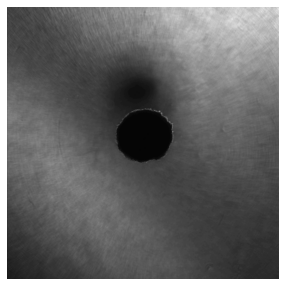

In [15]:
fnames_manual_plus_spheroidj_clear = get_image_files(path_manual_plus_spheroidj_clear_img)
lbl_names_manual_plus_spheroidj_clear = get_image_files(path_manual_plus_spheroidj_clear_lbl)

# open and show image
img_f = fnames_manual_plus_spheroidj_clear[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [16]:
print(get_y_fn(img_f))

../datasets/Labels/manual + spheroidj/805.tif


<AxesSubplot:>

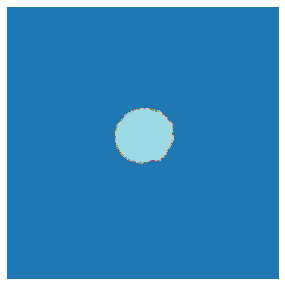

In [17]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
print(torch.max(image2tensor(mask)))

tensor(255, dtype=torch.uint8)


In [19]:
size = 1002
bs = 2

### No Data Augmentation

In [20]:
manual_spheroidj_clear = DataBlock(
    blocks=(ImageBlock, MaskRCNNBlock),
    get_items=partial(get_image_files,folders=[manual_spheroidj_name]),
    getters=getters,
    splitter=RandomSplitter(valid_pct=0.1,seed=2020),
    item_tfms=[IntToFloatTensorMaskRCNN],
    dl_type=TfmdDLV2,
    n_inp=1
)
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)

Setting-up type transforms pipelines
Found 1069 items
2 datasets of sizes 963,106
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: get_dict -> MaskRCNNDict.create

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying <lambda> gives
      ../datasets/Images/manual + spheroidj/42.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: get_dict -> MaskRCNNDict.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying get_dict gives
      {'boxes': TensorBBox([[ 77.,  94., 908., 877.]]), 'labels': TensorCategory([1]), 'masks': TensorMask([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)}
    applying MaskRCNNDict.create gives
      {'bo

WD=1e-4

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-4,
                                 splitter=maskrcnn_splitter)
# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

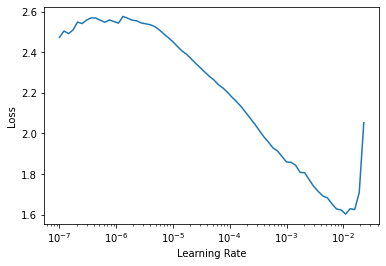

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.408335,0.548937,0.931613,0.848499,0.736864,01:41
1,0.320583,0.357699,0.917328,0.879271,0.784553,01:43
2,0.477820,0.428936,0.901903,0.841510,0.726385,01:44
3,0.317173,0.378360,0.901407,0.906828,0.829538,01:45


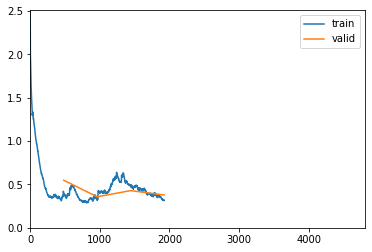

No improvement since epoch 1: early stopping


In [24]:
fname="maskrcnn-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-4-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-4,3e-3),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("maskrcnn-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-4-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.3819035589694977,0.917327880859375,0.8792713050139845,0.7845532187653643]

Recorder

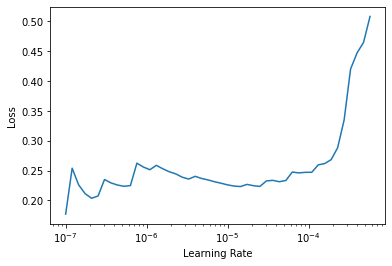

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.260782,0.249411,0.911859,0.899328,0.817071,03:15
1,0.175438,0.191544,0.905310,0.927133,0.864164,03:16
2,0.157494,0.170367,0.897643,0.932744,0.873965,03:17
3,0.150821,0.155629,0.903357,0.936427,0.880454,03:18
4,0.132708,0.143682,0.905609,0.940569,0.887806,03:17
5,0.127814,0.140148,0.907676,0.941764,0.889937,03:18
6,0.115173,0.134613,0.911532,0.944778,0.895336,03:18
7,0.106977,0.132961,0.914844,0.946142,0.897789,03:18
8,0.108687,0.131299,0.913225,0.946143,0.897791,03:18
9,0.113403,0.130092,0.912454,0.946322,0.898113,03:19


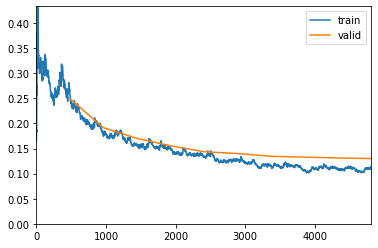

In [25]:
fname="maskrcnn-resnet50-manual-spheroidj-no-data-augmentation-after-unfreeze-WD-4-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(4e-6,1e-5),cbs=callbacksFitAfterUnfreeze)

WD=1e-3

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-3,
                                 splitter=maskrcnn_splitter)
# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

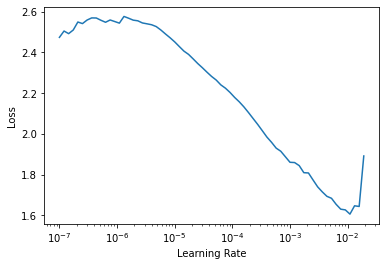

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.349299,0.304553,0.942726,0.810428,0.681277,01:43
1,0.329849,0.380277,0.919635,0.893064,0.806789,01:49
2,0.227115,0.454631,0.915946,0.918350,0.849027,01:53


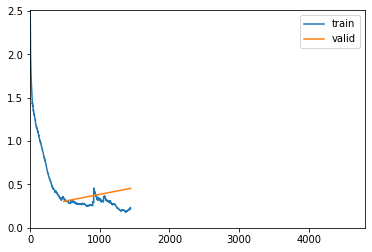

No improvement since epoch 0: early stopping


In [24]:
fname="maskrcnn-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-3-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("maskrcnn-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-3-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.32022395730018616,0.9427257180213928,0.8104279186841676,0.681276848551894]

Recorder

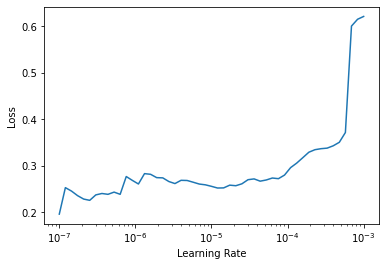

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.212775,0.228788,0.931073,0.874259,0.776608,03:18
1,0.160916,0.183637,0.924444,0.899294,0.817015,03:20
2,0.140211,0.157161,0.905427,0.940983,0.888544,03:27
3,0.124226,0.129305,0.905541,0.943108,0.892341,03:24
4,0.110930,0.122463,0.915944,0.947530,0.900291,03:29
5,0.106897,0.116374,0.919995,0.949412,0.903696,03:36
6,0.096903,0.111457,0.922546,0.950880,0.906359,03:33
7,0.088630,0.110614,0.925036,0.951726,0.907898,03:32
8,0.089070,0.110639,0.921717,0.951712,0.907872,03:34
9,0.092629,0.110347,0.921341,0.951720,0.907887,03:30


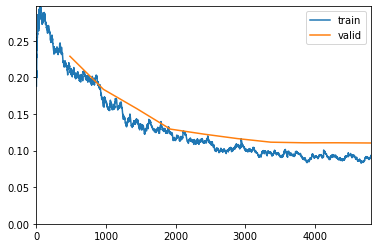

In [25]:
fname="maskrcnn-resnet50-manual-spheroidj-no-data-augmentation-after-unfreeze-WD-3-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(4e-6,1e-5),cbs=callbacksFitAfterUnfreeze)

WD=1e-2

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-2,
                                 splitter=maskrcnn_splitter)
# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

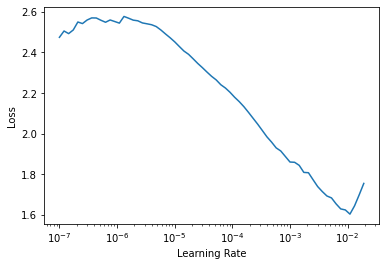

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.342427,0.300101,0.942242,0.815499,0.688475,01:48
1,0.234415,0.268180,0.921573,0.904112,0.825004,01:49
2,0.203757,0.219741,0.901613,0.927792,0.865310,01:51
3,0.175641,0.202560,0.912932,0.931124,0.871125,01:53
4,0.189027,0.179826,0.919003,0.936886,0.881266,01:52
5,0.153715,0.181419,0.920499,0.940576,0.887818,01:53
6,0.124042,0.153740,0.921987,0.944764,0.895310,01:53
7,0.112412,0.150096,0.920762,0.946370,0.898200,01:53
8,0.099841,0.143102,0.920089,0.948403,0.901869,01:53
9,0.102554,0.145648,0.920153,0.948428,0.901915,01:54


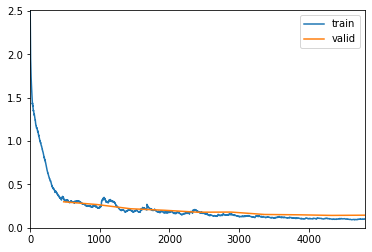

In [24]:
fname="maskrcnn-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("maskrcnn-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-2-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.16405467689037323,0.920089066028595,0.9484027369122369,0.9018687763863893]

Recorder

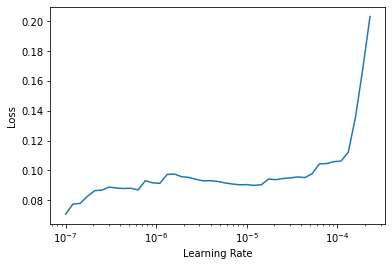

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.100321,0.143151,0.919808,0.948943,0.902846,03:28
1,0.093707,0.132189,0.920991,0.949934,0.904643,03:29
2,0.092788,0.126794,0.917395,0.949378,0.903635,03:29
3,0.089220,0.122046,0.919751,0.949854,0.904498,03:30
4,0.084452,0.119829,0.920281,0.951585,0.907642,03:33
5,0.087779,0.122059,0.920695,0.951238,0.907011,03:31
6,0.081292,0.123230,0.922221,0.952617,0.909521,03:29


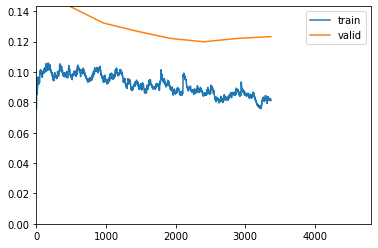

No improvement since epoch 4: early stopping


In [25]:
fname="maskrcnn-resnet50-manual-spheroidj-no-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-6,1e-5),cbs=callbacksFitAfterUnfreeze)

WD=1e-1

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-1,
                                 splitter=maskrcnn_splitter)
# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

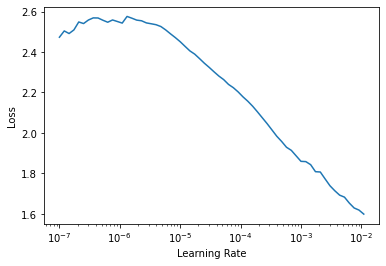

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.337804,0.292154,0.941027,0.830591,0.710266,01:48
1,0.222649,0.239917,0.903030,0.916037,0.845081,01:50
2,0.215626,0.231045,0.905638,0.928299,0.866193,01:52
3,0.170070,0.183836,0.910743,0.934045,0.876252,01:52
4,0.200359,0.175774,0.917654,0.936598,0.880756,01:52
5,0.153867,0.170123,0.921503,0.941130,0.888807,01:52
6,0.121458,0.146319,0.921249,0.945278,0.896234,01:53
7,0.111279,0.139797,0.921724,0.946919,0.899189,01:52
8,0.097768,0.133909,0.923578,0.949314,0.903517,01:53
9,0.100321,0.134080,0.921159,0.949298,0.903490,01:53


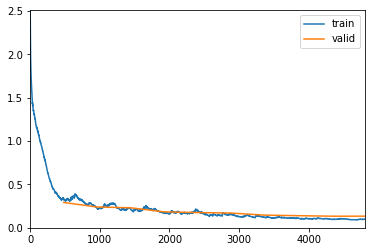

In [24]:
fname="maskrcnn-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("maskrcnn-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-1-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.1525505930185318,0.9235777854919434,0.9493135614185829,0.9035174782500262]

Recorder

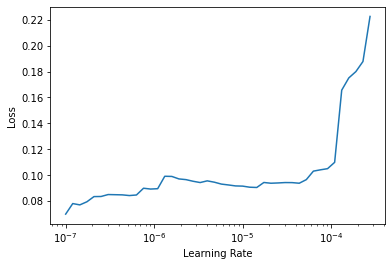

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.101779,0.131951,0.921811,0.949888,0.904559,03:28
1,0.093406,0.119172,0.924822,0.951222,0.906982,03:29
2,0.093634,0.142255,0.919479,0.950401,0.905490,03:29
3,0.087247,0.111119,0.922840,0.951751,0.907944,03:30
4,0.083623,0.112298,0.924642,0.952234,0.908824,03:29
5,0.083954,0.106885,0.925251,0.953304,0.910775,03:30
6,0.077281,0.107263,0.925800,0.954085,0.912202,03:31
7,0.072657,0.109702,0.924864,0.953821,0.911718,03:38


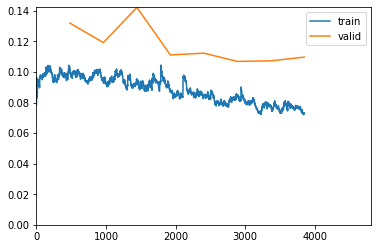

No improvement since epoch 5: early stopping


In [25]:
fname="maskrcnn-resnet50-manual-spheroidj-no-data-augmentation-after-unfreeze-WD-1-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(4e-6,1e-5),cbs=callbacksFitAfterUnfreeze)

#### Evaluation - Best hyperparameters

In [20]:
manual_spheroidj_clear = DataBlock(
    blocks=(ImageBlock, MaskRCNNBlock),
    get_items=partial(get_image_files,folders=[manual_spheroidj_name,test_name]),
    getters=getters,
    splitter=FuncSplitter(ParentSplitter),
    item_tfms=[IntToFloatTensorMaskRCNN],
    dl_type=TfmdDLV2,
    n_inp=1
)
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)

Setting-up type transforms pipelines
Found 1435 items
2 datasets of sizes 1069,366
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: get_dict -> MaskRCNNDict.create

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying <lambda> gives
      ../datasets/Images/manual + spheroidj/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: get_dict -> MaskRCNNDict.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying get_dict gives
      {'boxes': TensorBBox([[425., 382., 662., 600.]]), 'labels': TensorCategory([1]), 'masks': TensorMask([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)}
    applying MaskRCNNDict.create gives
      

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-1,
                                 splitter=maskrcnn_splitter)
# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

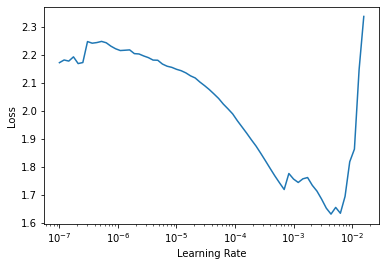

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.338534,0.341062,0.939904,0.858124,0.751503,02:34
1,0.219693,0.238542,0.907027,0.912642,0.839320,02:45
2,0.215945,0.209896,0.913635,0.920844,0.853301,02:45
3,0.160675,0.185352,0.926868,0.930760,0.870487,03:02
4,0.153564,0.174397,0.922413,0.934567,0.877170,02:35
5,0.130618,0.162611,0.922369,0.934931,0.877812,02:29
6,0.124124,0.148974,0.916325,0.938939,0.884906,02:30
7,0.106913,0.146946,0.924062,0.940186,0.887124,02:30
8,0.103594,0.143382,0.923223,0.941450,0.889376,02:27
9,0.096219,0.144177,0.925391,0.942336,0.890960,02:27


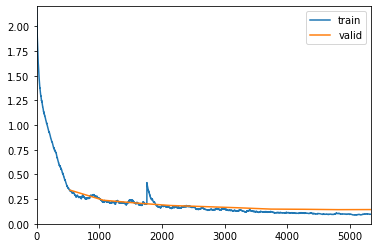

In [24]:
fname="maskrcnn-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(5e-5,5e-4),cbs=callbacksFitBeforeUnfreeze)

In [23]:
learn.load("maskrcnn-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


(#4) [0.1440255492925644,0.9253908395767212,0.9423362535533014,0.8909601531858791]

Recorder

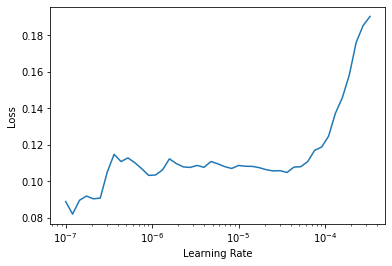

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.096797,0.143790,0.925471,0.942329,0.890948,04:10
1,0.098083,0.142084,0.923835,0.942683,0.891580,04:13
2,0.093056,0.140676,0.924194,0.943064,0.892263,04:13
3,0.091106,0.139231,0.925368,0.943390,0.892846,04:14
4,0.088421,0.138735,0.926043,0.943756,0.893501,04:14
5,0.086647,0.138002,0.925101,0.943881,0.893726,04:14
6,0.090374,0.137830,0.924589,0.943915,0.893787,04:14
7,0.086942,0.138500,0.925098,0.944168,0.894242,04:14
8,0.089473,0.138044,0.924889,0.944138,0.894186,04:13
9,0.086316,0.138195,0.924941,0.944159,0.894224,04:13


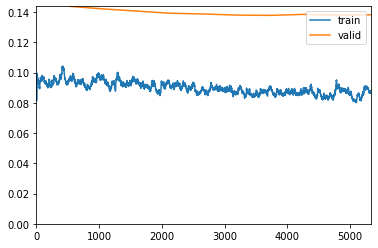

No improvement since epoch 7: early stopping


In [25]:
fname="maskrcnn-resnet50-manual-spheroidj-no-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(5e-7,9e-7),cbs=callbacksFitAfterUnfreeze)

In [22]:
learn.load("maskrcnn-resnet50-manual-spheroidj-no-data-augmentation-after-unfreeze-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.15693096816539764,0.9250978827476501,0.944168435397207,0.8942415315575509]

In [24]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("TorchScript models/mask-rcnn-dataset3-no-data-augmentation.pth")

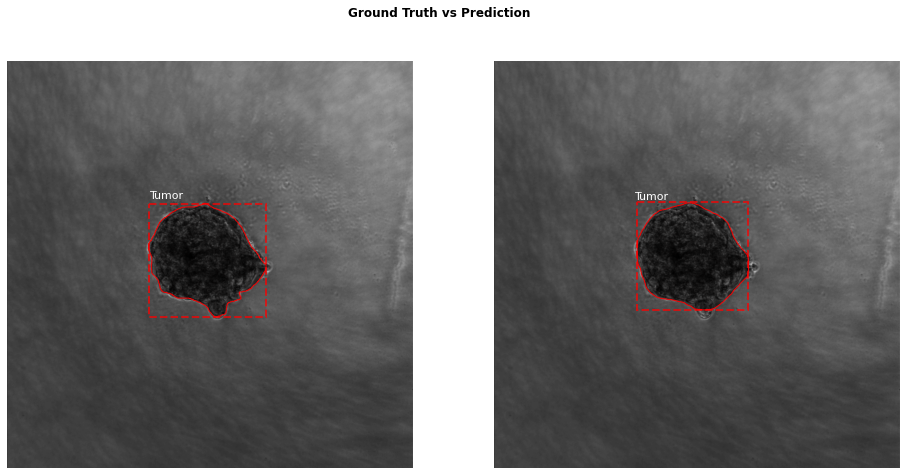

In [28]:
learn.show_results() # show results

### DataAugmentation

In [20]:
manual_spheroidj_clear = DataBlock(
    blocks=(ImageBlock, MaskRCNNBlock),
    get_items=partial(get_image_files,folders=[manual_spheroidj_name]),
    getters=getters,
    splitter=RandomSplitter(valid_pct=0.1,seed=2020),
    item_tfms=[transformPipeline,IntToFloatTensorMaskRCNN],
    dl_type=TfmdDLV2,
    n_inp=1
)
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)

Setting-up type transforms pipelines
Found 1069 items
2 datasets of sizes 963,106
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: get_dict -> MaskRCNNDict.create

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying <lambda> gives
      ../datasets/Images/manual + spheroidj/42.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: get_dict -> MaskRCNNDict.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying get_dict gives
      {'boxes': TensorBBox([[ 77.,  94., 908., 877.]]), 'labels': TensorCategory([1]), 'masks': TensorMask([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)}
    applying MaskRCNNDict.create gives
      {'bo

WD=1e-4

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-4,
                                 splitter=maskrcnn_splitter)
# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

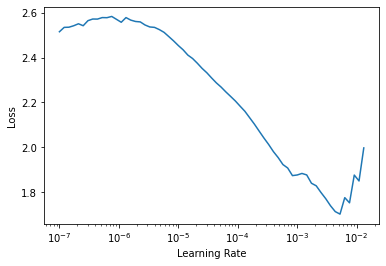

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.360180,0.289862,0.944386,0.837220,0.720015,01:48
1,0.269510,0.277503,0.905576,0.908872,0.832966,01:49
2,0.212569,0.266877,0.915490,0.929017,0.867443,01:47
3,0.272342,0.193703,0.909586,0.931841,0.872380,01:47
4,0.178301,0.202765,0.914636,0.937652,0.882623,01:47
5,0.167016,0.167709,0.924061,0.944685,0.895169,01:48
6,0.136988,0.149364,0.924541,0.943756,0.893501,01:48
7,0.123819,0.133165,0.920054,0.947797,0.900774,01:47
8,0.115860,0.123791,0.920015,0.947665,0.900535,01:48
9,0.121894,0.124508,0.920395,0.947239,0.899767,01:48


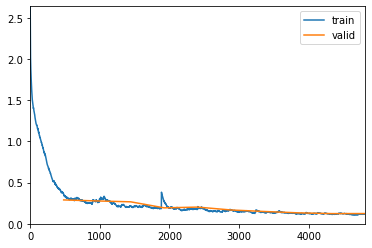

In [24]:
fname="maskrcnn-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-WD-4-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(8e-5,8e-4),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("maskrcnn-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-WD-4-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.14352966845035553,0.9200147390365601,0.9476646410255654,0.9005348275564194]

Recorder

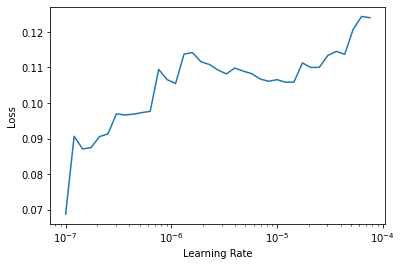

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.115786,0.121748,0.919802,0.948293,0.901670,03:21
1,0.109586,0.115049,0.921397,0.949813,0.904423,03:23
2,0.103667,0.108391,0.918569,0.949408,0.903688,03:23
3,0.101558,0.105266,0.919736,0.950987,0.906554,03:22
4,0.096903,0.102397,0.922758,0.952134,0.908641,03:29
5,0.100494,0.099057,0.922431,0.953304,0.910774,03:40
6,0.091766,0.096964,0.923814,0.953071,0.910349,03:39
7,0.088189,0.096828,0.923339,0.953308,0.910782,03:40
8,0.085714,0.096251,0.921676,0.953368,0.910891,03:42
9,0.094077,0.096024,0.920130,0.953629,0.911368,03:49


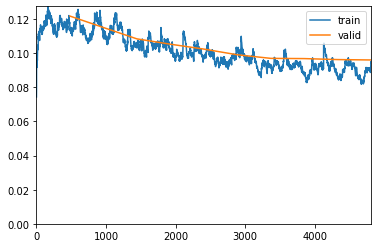

In [25]:
fname="maskrcnn-resnet50-manual-spheroidj-data-augmentation-after-unfreeze-WD-4-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(4e-6,8e-6),cbs=callbacksFitAfterUnfreeze)

WD=1e-3

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-3,
                                 splitter=maskrcnn_splitter)
# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

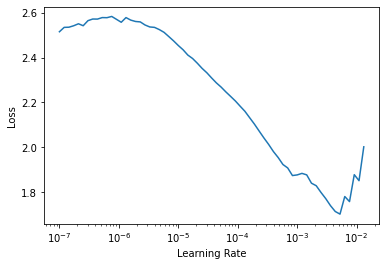

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.401700,0.316436,0.934617,0.854480,0.745932,01:59
1,0.230976,0.247503,0.905518,0.897192,0.813553,01:48
2,0.206417,0.262532,0.911250,0.925330,0.861037,01:45
3,0.173458,0.190184,0.909936,0.933661,0.875576,01:46
4,0.178601,0.161826,0.922274,0.939059,0.885119,01:46
5,0.162041,0.181724,0.923660,0.940535,0.887745,01:46
6,0.131208,0.143904,0.916777,0.943208,0.892519,01:46
7,0.120129,0.132112,0.919338,0.947552,0.900331,01:45
8,0.116646,0.126316,0.921518,0.947969,0.901084,01:46
9,0.126170,0.125099,0.918213,0.947557,0.900340,01:46


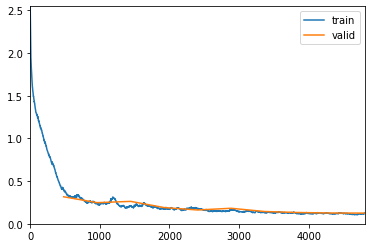

In [24]:
fname="maskrcnn-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-WD-3-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(5e-5,5e-4),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("maskrcnn-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-WD-3-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.14403706789016724,0.9182133674621582,0.9475568286483256,0.900340136590329]

Recorder

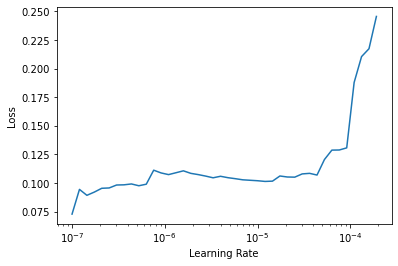

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.114122,0.121565,0.918527,0.948438,0.901932,03:17
1,0.107482,0.112076,0.919564,0.949258,0.903417,03:18
2,0.101837,0.104220,0.913802,0.949979,0.904724,03:18
3,0.103836,0.101626,0.917927,0.950675,0.905987,03:19
4,0.094747,0.100543,0.924302,0.952043,0.908475,03:19
5,0.099294,0.101815,0.919153,0.952465,0.909244,03:19
6,0.089919,0.095254,0.926354,0.953418,0.910983,03:18
7,0.085522,0.095785,0.924230,0.953591,0.911299,03:19
8,0.086867,0.094602,0.921720,0.953701,0.911499,03:18
9,0.092995,0.093850,0.921927,0.953791,0.911664,03:18


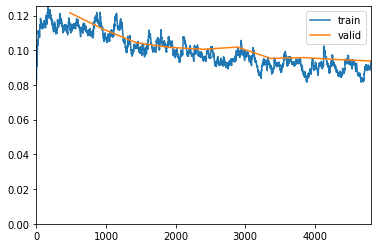

In [25]:
fname="maskrcnn-resnet50-manual-spheroidj-data-augmentation-after-unfreeze-WD-3-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(4e-6,1e-5),cbs=callbacksFitAfterUnfreeze)

WD=1e-2

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-2,
                                 splitter=maskrcnn_splitter)
# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

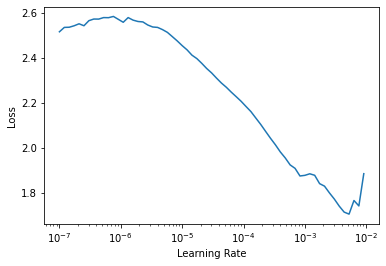

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.399218,0.349023,0.940069,0.847864,0.735906,01:43
1,0.232923,0.228741,0.895907,0.901474,0.820621,01:43
2,0.208904,0.218415,0.923553,0.915582,0.844307,01:45
3,0.170079,0.186902,0.900646,0.930494,0.870022,01:46
4,0.172561,0.171885,0.911540,0.941287,0.889086,01:45
5,0.163774,0.165688,0.924161,0.943711,0.893421,01:45
6,0.128800,0.137935,0.915854,0.945478,0.896594,01:45
7,0.119701,0.131544,0.919584,0.947661,0.900528,01:46
8,0.115501,0.127010,0.920934,0.948253,0.901598,01:45
9,0.125090,0.126788,0.918208,0.947757,0.900701,01:45


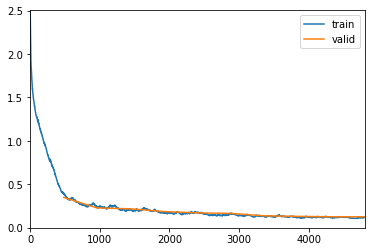

In [24]:
fname="maskrcnn-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(5e-5,5e-4),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("maskrcnn-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-WD-2-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.14563332498073578,0.9182083010673523,0.9477568594633753,0.900701390155926]

Recorder

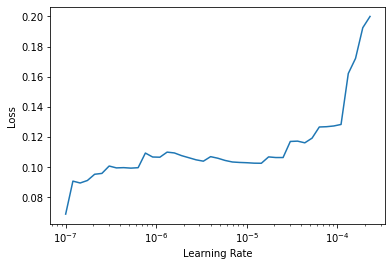

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.115337,0.120911,0.919605,0.949074,0.903083,03:18
1,0.110227,0.117984,0.923529,0.949349,0.903582,03:18
2,0.102579,0.108004,0.916583,0.950424,0.905531,03:19
3,0.102651,0.106428,0.920742,0.950664,0.905967,03:19
4,0.096682,0.101080,0.927381,0.952721,0.909710,03:19
5,0.098908,0.098643,0.922364,0.953759,0.911605,03:19
6,0.090223,0.094851,0.923666,0.953980,0.912009,03:19
7,0.085734,0.094787,0.925524,0.954067,0.912169,03:20
8,0.086585,0.093445,0.923783,0.954114,0.912254,03:19
9,0.094449,0.093428,0.923126,0.954022,0.912085,03:19


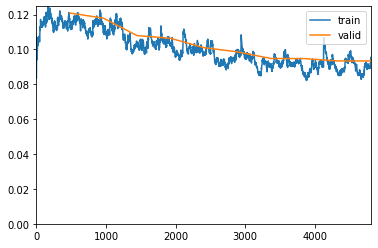

In [25]:
fname="maskrcnn-resnet50-manual-spheroidj-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(4e-6,1e-5),cbs=callbacksFitAfterUnfreeze)

WD=1e-1

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-1,
                                 splitter=maskrcnn_splitter)
# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

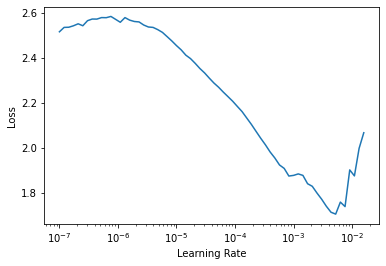

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.401996,0.347489,0.940367,0.848113,0.736281,01:44
1,0.230398,0.268823,0.923424,0.890607,0.802788,01:44
2,0.206853,0.238311,0.913402,0.915426,0.844043,01:46
3,0.169679,0.197177,0.906436,0.926400,0.862891,01:47
4,0.180887,0.168477,0.920781,0.940438,0.887572,01:47
5,0.150939,0.151717,0.925268,0.944340,0.894550,01:47
6,0.134315,0.137108,0.918861,0.944298,0.894473,01:47
7,0.121641,0.134754,0.917828,0.947074,0.899468,01:47
8,0.114697,0.127364,0.918277,0.947667,0.900539,01:47
9,0.122368,0.128171,0.919893,0.947700,0.900598,01:47


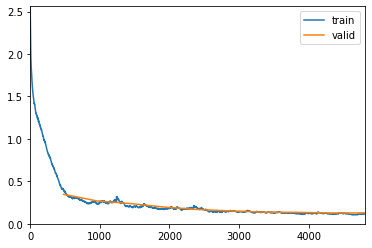

In [24]:
fname="maskrcnn-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(5e-5,5e-4),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("maskrcnn-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-WD-1-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.1471109539270401,0.9182766675949097,0.9476670054650365,0.9005390977822757]

Recorder

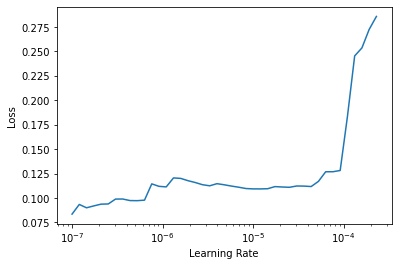

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.116157,0.121182,0.920811,0.948056,0.901242,03:22
1,0.104891,0.113369,0.917090,0.949441,0.903749,03:22
2,0.103450,0.105773,0.913504,0.950919,0.906431,03:23
3,0.105210,0.103781,0.916698,0.951066,0.906697,03:22
4,0.098654,0.101404,0.924491,0.952516,0.909337,03:23
5,0.099712,0.097126,0.919069,0.952983,0.910189,03:24
6,0.089690,0.095643,0.921428,0.953358,0.910873,03:24
7,0.085514,0.095637,0.924166,0.953537,0.911200,03:24
8,0.086390,0.095118,0.920830,0.953448,0.911037,03:23
9,0.091790,0.094723,0.921538,0.953456,0.911052,03:20


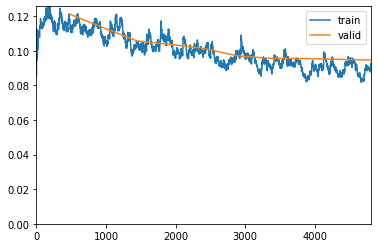

In [25]:
fname="maskrcnn-resnet50-manual-spheroidj-data-augmentation-after-unfreeze-WD-1-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(4e-6,1e-5),cbs=callbacksFitAfterUnfreeze)

#### Evaluation - Best hyperparameters

In [20]:
manual_spheroidj_clear = DataBlock(
    blocks=(ImageBlock, MaskRCNNBlock),
    get_items=partial(get_image_files,folders=[manual_spheroidj_name,test_name]),
    getters=getters,
    splitter=FuncSplitter(ParentSplitter),
    item_tfms=[transformPipeline, IntToFloatTensorMaskRCNN],
    dl_type=TfmdDLV2,
    n_inp=1
)
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)

Setting-up type transforms pipelines
Found 1435 items
2 datasets of sizes 1069,366
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: get_dict -> MaskRCNNDict.create

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying <lambda> gives
      ../datasets/Images/manual + spheroidj/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: get_dict -> MaskRCNNDict.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying get_dict gives
      {'boxes': TensorBBox([[425., 382., 662., 600.]]), 'labels': TensorCategory([1]), 'masks': TensorMask([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)}
    applying MaskRCNNDict.create gives
      

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=1002, metrics=[tumour, DiceMaskRCNN(), JaccardCoeffMaskRCNN()], wd=1e-2,
                                 splitter=maskrcnn_splitter)
# Just freezing backbone
learn.freeze_to(-2)

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Recorder

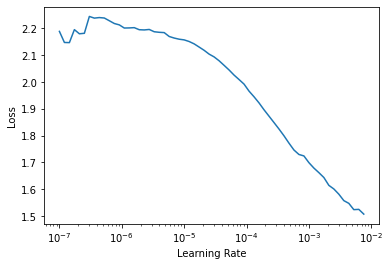

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.307705,0.309021,0.925886,0.884240,0.792500,02:29
1,0.275642,0.293858,0.916915,0.910029,0.834911,02:33
2,0.265881,0.233485,0.918718,0.910239,0.835264,02:33
3,0.179537,0.205081,0.917099,0.924343,0.859329,02:34
4,0.169279,0.197130,0.931023,0.932097,0.872830,02:28
5,0.155881,0.177596,0.923319,0.932417,0.873391,02:28
6,0.146898,0.165600,0.923288,0.936160,0.879982,02:29
7,0.130030,0.155888,0.920347,0.938612,0.884324,02:42
8,0.128706,0.149984,0.922028,0.939653,0.886174,02:43
9,0.121071,0.148432,0.927089,0.940656,0.887962,02:43


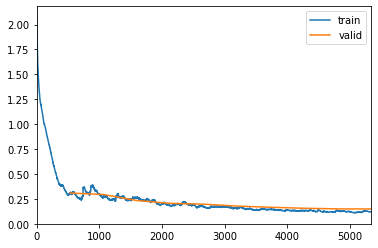

In [24]:
fname="maskrcnn-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [23]:
learn.load("maskrcnn-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2892: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587452831668/work/torch/csrc/utils/python_arg_parser.cpp:760: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


(#4) [0.1489434540271759,0.9270889759063721,0.9406564536040758,0.8879616596564514]

Recorder

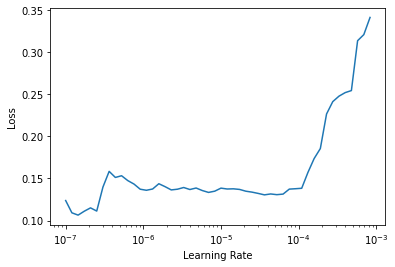

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.123439,0.147417,0.927883,0.941013,0.888598,04:31
1,0.122584,0.142910,0.927173,0.941775,0.889958,04:34
2,0.117013,0.139944,0.926892,0.942112,0.890559,04:17
3,0.110543,0.137480,0.927626,0.942043,0.890436,04:16
4,0.112720,0.135873,0.927147,0.942826,0.891836,04:17
5,0.106776,0.135876,0.926350,0.942882,0.891936,04:27
6,0.114100,0.134910,0.926667,0.943198,0.892503,04:31
7,0.108036,0.135611,0.926603,0.943157,0.892428,04:22
8,0.112812,0.133922,0.926369,0.943252,0.892599,04:16
9,0.106534,0.134676,0.926201,0.943263,0.892618,04:38


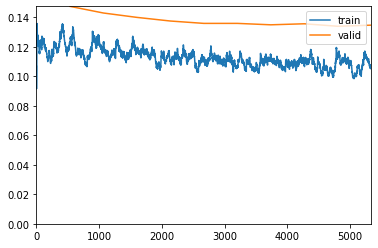

In [25]:
fname="maskrcnn-resnet50-manual-spheroidj-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(6e-7,1e-6),cbs=callbacksFitAfterUnfreeze)

In [22]:
learn.load("maskrcnn-resnet50-manual-spheroidj-data-augmentation-after-unfreeze-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(#4) [0.15653273463249207,0.9262006878852844,0.9432625881322653,0.892617766286037]

In [24]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("TorchScript models/mask-rcnn-dataset3-data-augmentation.pth")

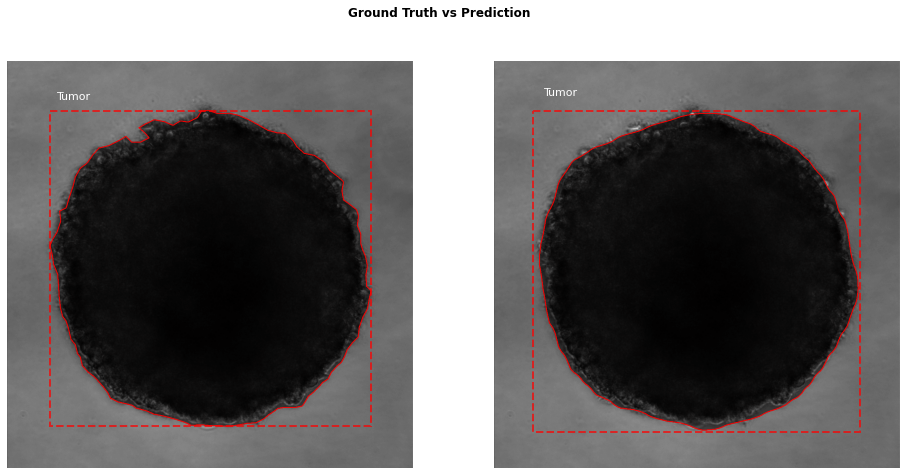

In [32]:
learn.show_results() # show results